# DBSCAN

DBSCAN published in 1996 is a popular density-based clustering algorithm. 

# DBSCAN in Scikit-Learn

Let's create two moons.

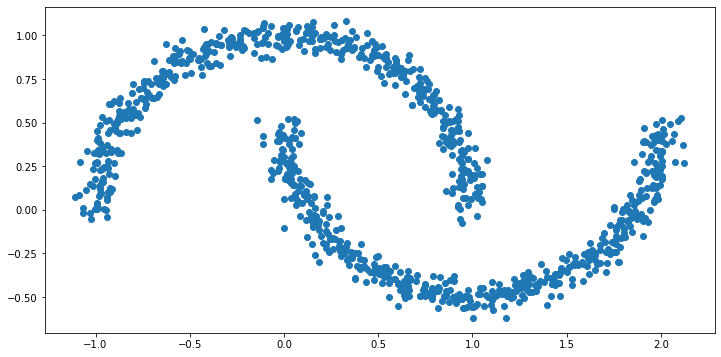

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from sklearn.cluster import DBSCAN, KMeans
from sklearn.datasets import make_moons
from sklearn.metrics.pairwise import euclidean_distances

X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)
plt.figure(figsize=(12, 6))
plt.scatter(X[:,0], X[:,1])
plt.show()

Now, we cluster the two moons with a random combination of parameters.

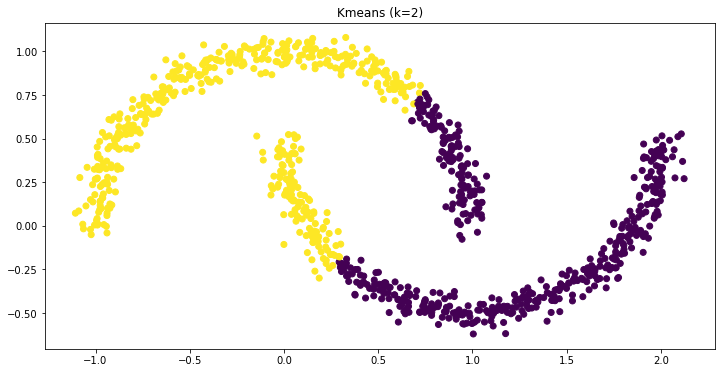

In [2]:
km = KMeans(n_clusters=2)
km.fit(X)
plt.figure(figsize=(12, 6))
# Plot the clusters
plt.scatter(X[:, 0], X[:, 1], c=km.labels_)
plt.title(f"Kmeans (k=2)")
plt.show()

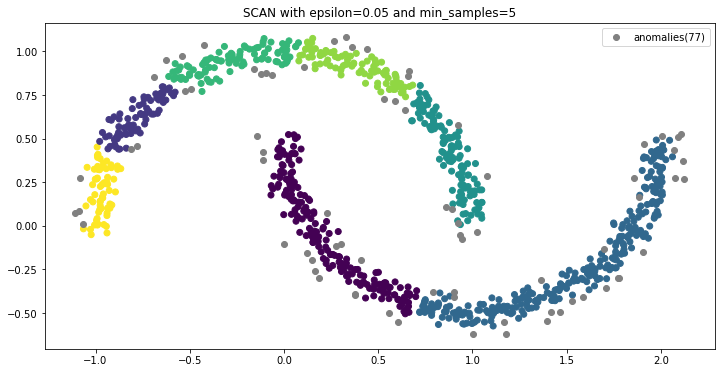

In [3]:
def cluster_and_plot(epsilon, min_samples):
    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
    dbscan.fit(X)
    plt.figure(figsize=(12, 6))
    # Plot the clusters
    plt.scatter(X[dbscan.labels_>-1, 0], X[dbscan.labels_>-1, 1], c=dbscan.labels_[dbscan.labels_>-1])
    # plot anomolies
    anomaly_predicates = dbscan.labels_==-1
    n_anomalies = sum(anomaly_predicates)
    plt.scatter(X[anomaly_predicates, 0], X[anomaly_predicates, 1], c='gray', label=f'anomalies({n_anomalies})')
    plt.title(f"SCAN with epsilon={epsilon} and min_samples={min_samples}")
    plt.legend()
    plt.show()

cluster_and_plot(0.05, 5)

In [4]:
# cluster_and_plot(0.03, 4)

From the above picture, we can see that we got 7 clusters and 77 anomalies. We need to adjust the parameters to make two clusters.

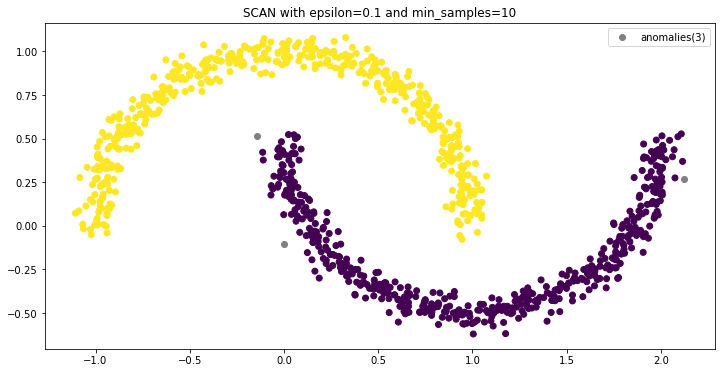

In [5]:
cluster_and_plot(0.1, 10)

After we adjusted the parameters, we successfully clustered the data to two clusters with 3 anomalies.
# DBSCAN from Scratch

## Step 1 find cores

The first step of this algorithm is to find the cores. A core is a point within the radius of *epsilon* there are as least *min_samples* other points (neighbours). 

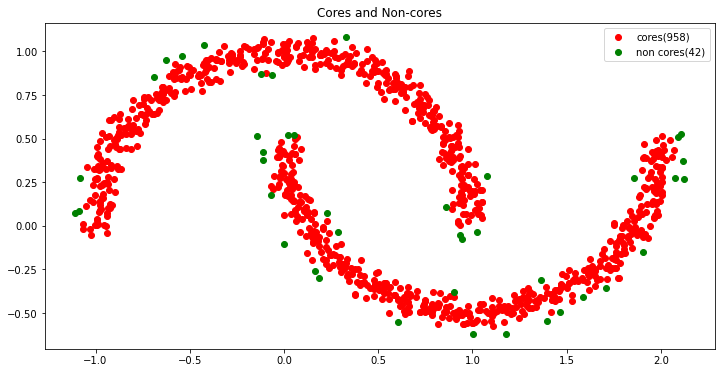

In [6]:
# set the parameters
epsilon = 0.1
min_samples = 10
# In most of the cluster algorithms, the first step is to calculate the distance matrix.
distance_matrix=euclidean_distances(X)
neighbour_predicate_matrix = distance_matrix<=epsilon
neighbour_counts_array=neighbour_predicate_matrix.sum(axis=0)
core_predicates = neighbour_counts_array>=min_samples
indices = np.arange(0, 1000)
core_indices = indices[core_predicates]
non_core_indices = indices[~core_predicates]
n_cores = sum(core_predicates)
n_non_cores = 1000-n_cores

plt.figure(figsize=(12, 6))
# cores
plt.scatter(X[core_indices,0], X[core_indices,1], c='r', label=f"cores({n_cores})" )
plt.scatter(X[non_core_indices,0], X[non_core_indices,1], c='g', label=f"non cores({n_non_cores})")
plt.legend()
plt.title("Cores and Non-cores")
plt.show()

## Step 2 connect cores

In [7]:
labels = -np.ones((1000,), dtype=np.int)
cluster_id=0
loop_index=0
while sum(labels<0) > 0:
    #unlabelled_predicates = (labels==-1)
    unlabelled_core_predicates = ((core_predicates) & (labels==-1))
    unlabelled_core_indices = indices[unlabelled_core_predicates]
    if len(unlabelled_core_indices) == 0:
        break
    first_index=unlabelled_core_indices[0]
    neighbourhood_predicates = neighbour_predicate_matrix[first_index]
    neighbourhood_indices = indices[core_predicates & neighbourhood_predicates]
    
    while(len(neighbourhood_indices)>0):
        # it would make the file too big...
#         fig, ax = plt.subplots(figsize=(12, 6))
#         fig.facecolor='white'
#         circle = Circle((X[first_index, 0], X[first_index, 1]), 0.1, facecolor='none',
#                         edgecolor=(0, 0.8, 0.8), linewidth=3, alpha=0.5)
#         ax.add_patch(circle)

#         # plt.figure(figsize=(10, 8))
#         # cores
#         plt.scatter(X[core_indices,0], X[core_indices,1], c='r')
#         plt.scatter(X[non_core_indices,0], X[non_core_indices,1], c='g')
#         # clustered
#         plt.scatter(X[labels>=0,0], X[labels>=0,1], c=labels[labels>=0])
#         # and its neighourhood
#         plt.scatter(X[neighbourhood_indices, 0], X[neighbourhood_indices, 1], c="tab:blue", marker='o')
#         # draw first 
#         plt.scatter(X[first_index, 0], X[first_index, 1], c="tab:cyan", marker='o')
#         plt.title(f"Cluster {cluster_id}, Loop {loop_index}")
#         plt.show()
#         # plt.savefig(f"tmp/{loop_index}.png")
#         plt.clf()
        
        labels[neighbourhood_indices] = cluster_id
        unlabelled_predicates = (labels==-1)
        neighbourhood_predicates_matrix = neighbour_predicate_matrix[neighbourhood_indices]
        neighbourhood_predicates = neighbourhood_predicates_matrix.any(axis=0)
        
        neighbourhood_indices = indices[(core_predicates & neighbourhood_predicates & unlabelled_predicates)]
        
        loop_index+=1
        # break
    cluster_id+=1

## Step 3 cluster non-core points and anomalies
Now we have connected all the cores and clustered them to two clusters. The next step is to find non-core points which are close (distance < epsilon) to the cores. They will be consider as the same cluster with the core that they are close to. The left ones will be anomalies.

In [8]:
clusters = np.unique(labels) 
for cluster_id in [c for c in clusters if c>-1]:
    # find the points that are already clusterd to cluster_id
    cluster_predicates = labels==cluster_id
    # find the neighours of the above
    neighbours_matrix = neighbour_predicate_matrix[cluster_predicates]
    neighbours_predicates = neighbours_matrix.any(axis=0)
    # remove the already clustered points from the neighourhood.
    clustered_non_core_indices=indices[neighbours_predicates & ~cluster_predicates]
    # label the rest neighours.
    labels[clustered_non_core_indices] = cluster_id
    


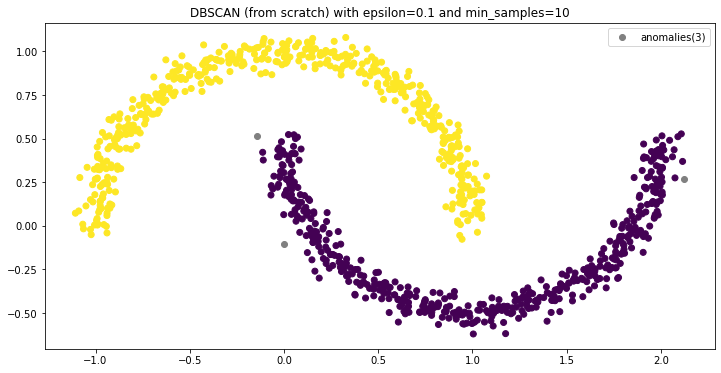

<Figure size 432x288 with 0 Axes>

In [9]:
plt.figure(figsize=(12, 6))
# cores
#plt.scatter(X[core_indices,0], X[core_indices,1], c='r')
#plt.scatter(X[non_core_indices,0], X[non_core_indices,1], c='g')
anomaly_predicates = labels==-1
# clustered
plt.scatter(X[~anomaly_predicates,0], X[~anomaly_predicates,1], c=labels[labels>=0])
# anomalies

n_anomalies = sum(anomaly_predicates)
plt.scatter(X[anomaly_predicates,0], X[anomaly_predicates,1], c='gray', label=f'anomalies({n_anomalies})')
plt.legend()
plt.title("DBSCAN (from scratch) with epsilon=0.1 and min_samples=10")
plt.show()
# plt.savefig(f"tmp/{loop_index}.png")
plt.clf()

We can see that this chart is identical to the one produced by sklearn.

# Reference

Book: *Hands-on Machine Learning with Scikit-Learn and Tensorflow*

Paper: DBSCAN Revisited, Revisited: Why and How You Should (Still) Use DBSCAN